In [1]:
#!pip uninstall -q torchattacks
#!pip install -q git+https://github.com/mohanrajroboticist/adversarial-attacks-pytorch 
#!pip install torchattacks -q

In [2]:
import torch
import torchvision
from torchvision.models import ResNet18_Weights
import numpy as np
import matplotlib.pyplot as plt
import copy
from torch.quantization import quantize_fx
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings("ignore")
import torchattacks
from sklearn.metrics import accuracy_score


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def load_test_data(data_dir):
    #transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])
    transform = transforms.Compose([transforms.ToTensor()])
    testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)   
    return testset
data_dir = '../../data'
tes = load_test_data(data_dir)
testloader = torch.utils.data.DataLoader(tes, batch_size=100, shuffle=False, num_workers=2)
dataloader = {"test": testloader}
dataiter = iter(dataloader['test'])
img, lab = next(dataiter)

Files already downloaded and verified


In [3]:
# model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)


# if parameters['quantise'] == True:
#     m = copy.deepcopy(model)
#     m.to("cpu")
#     m.eval()
#     qconfig_dict = {"": torch.quantization.get_default_qconfig("fbgemm")}
#     model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, img)
#     with torch.inference_mode():
#         for _ in range(10):
#             img, lab = next(dataiter)
#             model_prepared(img)
#     q_model = quantize_fx.convert_fx(model_prepared)
#     test_out = q_model(img)
#     print("model quantisation success")

In [4]:
from helpers import get_model

parameters = {  'num_classes': 10, 
                #'model_name':'LeNet',
                'model_name':'Resnet18',
                #'loss_function':'Evidential_MSE',
                #'loss_function':'Evidential_LOG',
                #'loss_function':'Evidential_DIGAMMA',
                'loss_function': 'Crossentropy'
             }


models_path = '../../results/'


model_path = str(models_path)+str(parameters['loss_function'])+'_'+str(parameters['model_name'])+'_model.pth'
model = get_model(parameters['model_name'],num_classes=parameters['num_classes'],weights=None)
model.load_state_dict(torch.load(model_path))


model_path = str(models_path)+str(parameters['loss_function'])+'_'+str(parameters['model_name'])+'_quant_model.pth'
net = get_model(parameters['model_name'],num_classes=parameters['num_classes'],weights=None)
m = copy.deepcopy(net)
m.to("cpu")
m.eval()
qconfig_dict = {"": torch.quantization.get_default_qconfig("fbgemm")}
model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, img)
with torch.inference_mode():
    for _ in range(10):
        img, lab = next(dataiter)
        model_prepared(img)
q_model = quantize_fx.convert_fx(model_prepared)
test_out = q_model(img)
q_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
model.eval()
model.to('cpu')
q_model.eval()
q_model.to('cpu')


inputs, labels = next(dataiter)
inputs.to('cpu')
labels.to('cpu')
true_labels = np.array(labels)

In [6]:
def run_test(net, images):
    with torch.no_grad():
        out = net(images)
        _, preds = torch.max(out, 1)
        predict_labels = np.array(preds)

    accuracy = accuracy_score(true_labels, predict_labels)
    return accuracy

In [7]:
acc = run_test(model, inputs)
print("Standard WO ADV: ", acc)
acc = run_test(q_model, inputs)
print("Quantise WO ADV: ", acc)

atk = torchattacks.EADL1(model, torch.device('cpu'), kappa=8)
adv_images = atk(inputs, labels)
acc = run_test(model, adv_images)
print("Standard W  ADV: ", acc)

atk = torchattacks.EADL1(q_model, torch.device('cpu'), kappa=8)
adv_images = atk(inputs, labels)
acc = run_test(q_model, adv_images)
print("Quantise W  ADV: ", acc)

Standard WO ADV:  0.27
Quantise WO ADV:  0.3
Standard W  ADV:  0.0
Quantise W  ADV:  0.3


In [8]:
def imshow(img):    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

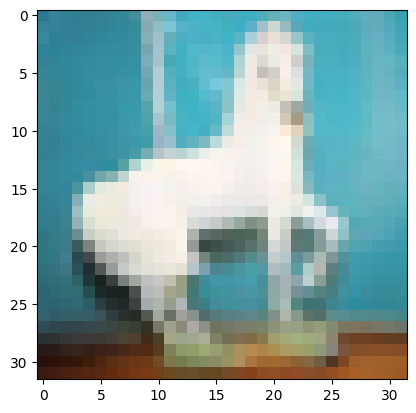

In [9]:
imshow(inputs[0])

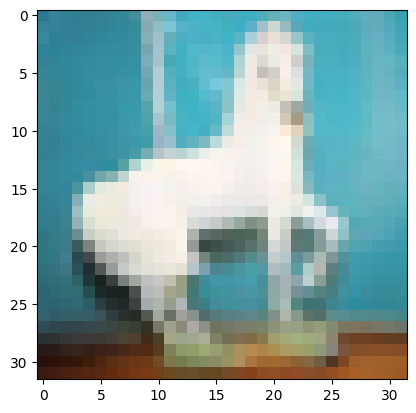

In [10]:
imshow(adv_images[0])